In [61]:
import numpy as np
#import sys
#np.set_printoptions(threshold=sys.maxsize)  #stop truncation of output
import numexpr   #(speeds up numpy + pandas)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
import plotly

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pmdarima as pm
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels as sm
from scipy import stats

from scipy.stats import norm
from sklearn.metrics import mean_squared_error 

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

from datetime import datetime
from pytz import timezone
import pytz

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_excel('BAYSHOR2_df - combined4.xlsm')
print(len(df))
df.head()

28464


,Date_time,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Conditions
0,2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,Partially cloudy
1,2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,Partially cloudy
2,2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,Partially cloudy
3,2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,Partially cloudy
4,2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,Partially cloudy


## OneHotEncoding - 'Conditions'

In [3]:
categories = np.array(df['Conditions'])                #converting 'Conditions' column to np.array 
categories

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Clear', 'Clear', 'Clear'], dtype=object)

In [4]:
label_encoder = LabelEncoder()                        #transforming np.array to integers with LabelEncoder
categories_encoded = label_encoder.fit_transform(categories)
print(categories_encoded)

[2 2 2 ... 0 0 0]


In [5]:
len(categories_encoded)

28464

In [6]:
df['Conditions'].value_counts()

Clear               17847
Partially cloudy     6305
Overcast             4235
Rain                   77
Name: Conditions, dtype: int64

In [7]:
onehot_encoder = OneHotEncoder(drop='first', sparse=False)                        #OneHotEncoding integers
integer_encoded = categories_encoded.reshape(len(categories_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [8]:
df2 = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names())
df2.head()                                                       #creating a DataFrame with OneHotEncoded integers

,x0_1,x0_2,x0_3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [10]:
df2['Overcast'] = df2['x0_1']               # renaming columns
df2['Partially cloudy'] = df2['x0_2']
df2['Rain'] = df2['x0_3']
df2.drop(['x0_1', 'x0_2', 'x0_3'], axis=1, inplace=True)
df2.head()

,Overcast,Partially cloudy,Rain
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [11]:
df3 = pd.concat([df,df2], axis=1)                       #Concatenating new DataFrame with original
df3.drop('Conditions', axis=1, inplace=True)           #dropping "Conditions" column after OneHotEncoding
df3['Date_time'] = pd.to_datetime(df3['Date_time'])    #setting column "Date_time" to Pandas Datetime
df3.set_index('Date_time', inplace=True)               #setting the index as "Date_time"
df3.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain
Date_time,,,,,,,,
2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,0.0,1.0,0.0
2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,0.0,1.0,0.0
2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,0.0,1.0,0.0
2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,0.0,1.0,0.0
2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,0.0,1.0,0.0


In [ ]:
## df3 = pd.DataFrame.sparse.from_spmatrix(x)  ## another way to create the dataframe

In [12]:
df3.isnull().sum()    #No missing values

Dollars_per_mwh     0
Temperature         0
Precipitation       0
Wind Speed          0
Cloud Cover         0
Overcast            0
Partially cloudy    0
Rain                0
dtype: int64

## Feature Engineering - Creating 'Is_holiday'

In [79]:
import datetime as dt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=df3.index.min(), end=df3.index.max())

df3['Is_holiday'] = df3.index.normalize().isin(holidays)
df3["Is_holiday"] = df3["Is_holiday"].astype(int)
df3.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week
Date_time,,,,,,,,,,,,
2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,0.0,1.0,0.0,0,2017-03-26 00:00:00,3,6
2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,0.0,1.0,0.0,0,2017-03-26 01:00:00,3,6
2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,0.0,1.0,0.0,0,2017-03-26 02:00:00,3,6
2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,0.0,1.0,0.0,0,2017-03-26 03:00:00,3,6
2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,0.0,1.0,0.0,0,2017-03-26 04:00:00,3,6


## Feature Engineering - Creating 'month', 'day_of_week' and 'hour_of_day'

In [147]:
df3['date_and_time'] = df3.index

df3['month'] = df3['date_and_time'].dt.month
df3['day_of_week'] = df3['date_and_time'].dt.dayofweek
df3['hour_of_day'] = df3['date_and_time'].dt.hour
df3.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day
Date_time,,,,,,,,,,,,,
2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,0.0,1.0,0.0,0,2017-03-26 00:00:00,3,6,0
2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,0.0,1.0,0.0,0,2017-03-26 01:00:00,3,6,1
2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,0.0,1.0,0.0,0,2017-03-26 02:00:00,3,6,2
2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,0.0,1.0,0.0,0,2017-03-26 03:00:00,3,6,3
2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,0.0,1.0,0.0,0,2017-03-26 04:00:00,3,6,4


## Feature Engineering - Creating 't-1' and 't-24'

In [148]:
cl = list(df3.columns)
cl.append('Dollars_per_mwh_t-1')
cl.append('Dollars_per_mwh_t-24')
print(cl)

['Dollars_per_mwh', 'Temperature', 'Precipitation', 'Wind Speed', 'Cloud Cover', 'Overcast', 'Partially cloudy', 'Rain', 'Is_holiday', 'date_and_time', 'month', 'day_of_week', 'hour_of_day', 'Dollars_per_mwh_t-1', 'Dollars_per_mwh_t-24']


In [149]:
mwh = pd.DataFrame(df3['Dollars_per_mwh'])               
df4 = pd.concat([df3, mwh.shift(1), mwh.shift(24)], axis=1) #feature engineering - adding columns for 't-1' 't-24'
df4.columns = cl
df4.head(30)

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24
Date_time,,,,,,,,,,,,,,,
2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,0.0,1.0,0.0,0,2017-03-26 00:00:00,3,6,0,NaN,NaN
2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,0.0,1.0,0.0,0,2017-03-26 01:00:00,3,6,1,9.75524,NaN
2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,0.0,1.0,0.0,0,2017-03-26 02:00:00,3,6,2,5.19205,NaN
2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,0.0,1.0,0.0,0,2017-03-26 03:00:00,3,6,3,4.14945,NaN
2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,0.0,1.0,0.0,0,2017-03-26 04:00:00,3,6,4,7.98666,NaN
2017-03-26 05:00:00,14.84628,53.4,0.0,5.3,95.6,1.0,0.0,0.0,0,2017-03-26 05:00:00,3,6,5,8.66210,NaN
2017-03-26 06:00:00,25.65554,53.9,0.0,5.2,95.6,1.0,0.0,0.0,0,2017-03-26 06:00:00,3,6,6,14.84628,NaN
2017-03-26 07:00:00,25.30807,53.9,0.0,4.4,100.0,1.0,0.0,0.0,0,2017-03-26 07:00:00,3,6,7,25.65554,NaN
2017-03-26 08:00:00,0.54441,53.9,0.0,4.7,100.0,1.0,0.0,0.0,0,2017-03-26 08:00:00,3,6,8,25.30807,NaN


In [150]:
print(len(df4))        #dropped 1st 24 rows to drop Nans from column 't-24'
df4.dropna(inplace=True)
print(len(df4))
df4.head()

28464
28440


,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24
Date_time,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,3,0,0,17.65826,9.75524
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,3,0,1,6.19784,5.19205
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,3,0,2,2.89189,4.14945
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,0,3,2.73622,7.98666
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,3,0,4,2.88942,8.66210


## OneHotEncoding - 'month'

In [151]:
month = np.array(df4['month'])                  #converting 'month' column to np.array 
print(month)
# label_encoder = LabelEncoder()                # np.array doesn't need to be transformed to integers with LabelEncoder
# month_encoded = label_encoder.fit_transform(month)
# print(categories_encoded)

[3 3 3 ... 6 6 6]


In [152]:
onehot_encoder = OneHotEncoder(drop='first', sparse=False)                  #OneHotEncoding integers
month_encoded = month.reshape(len(month), 1)
onehot_encoded = onehot_encoder.fit_transform(month_encoded)
print(onehot_encoded)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [162]:
months = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
matrix = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names())
matrix.head()                                        #creating a DataFrame with OneHotEncoded integers

,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
matrix.columns = ['February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
matrix.tail()

,February,March,April,May,June,July,August,September,October,November,December
28435,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28436,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28437,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28438,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28439,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
df5 = pd.concat([df4, matrix], axis=1)                       #Concatenating new DataFrame with original
df5.drop(['month', 'date_and_time'], axis=1, inplace=True)                     #dropping "month" column after OneHotEncoding

# df5['Date_time'] = pd.to_datetime(df5['Date_time'])    #setting column "Date_time" to Pandas Datetime
# df5.set_index('Date_time', inplace=True)               #setting the index as "Date_time"
df5.head()

ValueError: Shape of passed values is (56884, 26), indices imply (56880, 26)

In [156]:
print(np.shape(df4))
print(np.shape(matrix))

(28440, 15)
(28440, 11)


In [159]:
df4.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24
Date_time,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,3,0,0,17.65826,9.75524
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,3,0,1,6.19784,5.19205
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,3,0,2,2.89189,4.14945
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,0,3,2.73622,7.98666
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,3,0,4,2.88942,8.66210


In [175]:
matrix.index

RangeIndex(start=0, stop=28440, step=1)

In [176]:
df4.reset_index(drop=True, inplace=True)
matrix.reset_index(drop=True, inplace=True)
df5 = pd.concat([df4, matrix], axis=1)
df5.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December
0,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,3,0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,3,0,1,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,3,0,2,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,0,3,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,3,0,4,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
df5['Date_time'] = pd.to_datetime(df5['date_and_time'])    #setting column "Date_time" to Pandas Datetime
df5.set_index('Date_time', inplace=True)                   #setting the index as "Date_time"
df5.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,3,0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,3,0,1,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,3,0,2,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,0,3,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,3,0,4,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28440 entries, 0 to 28439
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Dollars_per_mwh       28440 non-null  float64       
 1   Temperature           28440 non-null  float64       
 2   Precipitation         28440 non-null  float64       
 3   Wind Speed            28440 non-null  float64       
 4   Cloud Cover           28440 non-null  float64       
 5   Overcast              28440 non-null  float64       
 6   Partially cloudy      28440 non-null  float64       
 7   Rain                  28440 non-null  float64       
 8   Is_holiday            28440 non-null  int64         
 9   date_and_time         28440 non-null  datetime64[ns]
 10  month                 28440 non-null  int64         
 11  day_of_week           28440 non-null  int64         
 12  hour_of_day           28440 non-null  int64         
 13  Dollars_per_mwh_

## OneHotEncoding - 'day_of_week'

In [182]:
day = np.array(df5['day_of_week'])                                   #converting 'day_of_week' column to np.array 
print(day)
onehot_encoder = OneHotEncoder(drop='first', sparse=False)           #OneHotEncoding
day_encoded = day.reshape(len(day), 1)
onehot_encoded = onehot_encoder.fit_transform(day_encoded)          
print(onehot_encoded)

[0 0 0 ... 1 1 1]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [185]:
matrix1 = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names())          #creating sparse matrix
matrix1.columns = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']      #renaming columns
matrix1.reset_index(drop=True, inplace=True)                              #error concatenating, dropping both indexes
df5.reset_index(drop=True, inplace=True)
df6 = pd.concat([df5, matrix1], axis=1)                                   #concatind datafram and sparse matrix
df6['Date_time'] = pd.to_datetime(df6['date_and_time'])                   #setting column "Date_time" Datetime
df6.set_index('Date_time', inplace=True)                                  #restting index to datetime
df6.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,month,day_of_week,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,3,0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,3,0,1,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,3,0,2,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,0,3,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,3,0,4,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
df6.drop(['month', 'day_of_week'], axis=1, inplace=True)
df6.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,1,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,2,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,4,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## OneHotEncoding - 'hour_of_day'

In [188]:
hour = np.array(df6['hour_of_day'])                                   #converting 'hour_of_day' column to np.array 
print(hour)
onehot_encoder = OneHotEncoder(drop='first', sparse=False)           #OneHotEncoding
hour_encoded = hour.reshape(len(hour), 1)
onehot_encoded = onehot_encoder.fit_transform(hour_encoded)          
print(onehot_encoded)

[ 0  1  2 ... 21 22 23]
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [193]:
matrix2 = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names())          #creating sparse matrix
matrix2.columns = ['1_hour','2_hour', '3_hour', '4_hour', '5_hour', '6_hour', '7_hour', 
                  '8_hour', '9_hour', '10_hour', '11_hour', '12_hour', '13_hour',
                  '14_hour', '15_hour', '16_hour', '17_hour', '18_hour', '19_hour',
                  '20_hour', '21_hour', '22_hour', '23_hour']                               #renaming columns
matrix2.reset_index(drop=True, inplace=True)                              #error concatenating, dropping both indexes
df6.reset_index(drop=True, inplace=True)
df6 = pd.concat([df6, matrix2], axis=1)                                   #concatind datafram and sparse matrix
df6['Date_time'] = pd.to_datetime(df6['date_and_time'])                   #setting column "Date_time" Datetime
df6.set_index('Date_time', inplace=True)                                  #restting index to datetime
df6.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,date_and_time,hour_of_day,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,2017-03-27 00:00:00,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,2017-03-27 01:00:00,1,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2017-03-27 02:00:00,2,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2017-03-27 03:00:00,3,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2017-03-27 04:00:00,4,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
df6.drop(['date_and_time', 'hour_of_day'], axis=1, inplace=True)
df6.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
df6.to_csv('Exogenous_variables.csv')

## Modeling

In [4]:
df6 = pd.read_csv('Exogenous_variables.csv')

In [5]:
df6.head()

,Date_time,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour
0,2017-03-27 00:00:00,6.19784,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-03-27 01:00:00,2.89189,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-03-27 02:00:00,2.73622,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-03-27 03:00:00,2.88942,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-03-27 04:00:00,5.18543,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
exogenous = df6.drop(['Dollars_per_mwh'], axis=1, inplace=False)   #seperating exogenous variables form time series

In [8]:
exogenous.head()

,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour
0,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
ts = df6['Dollars_per_mwh']   #time series without exogenous variables
ts.head()

0    6.19784
1    2.89189
2    2.73622
3    2.88942
4    5.18543
Name: Dollars_per_mwh, dtype: float64

In [8]:
tim = exogenous['Date_time']   #adding datetime back to time series
tim.head()

0    2017-03-27 00:00:00
1    2017-03-27 01:00:00
2    2017-03-27 02:00:00
3    2017-03-27 03:00:00
4    2017-03-27 04:00:00
Name: Date_time, dtype: object

In [9]:
exogenous['Date_time'] = pd.to_datetime(exogenous['Date_time'])          #setting column "Date_time" Datetime
exogenous.set_index('Date_time', inplace=True)                       #setting 'Date_time' as index
exogenous.head()

,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain,Is_holiday,Dollars_per_mwh_t-1,Dollars_per_mwh_t-24,February,March,April,May,June,July,August,September,October,November,December,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour
Date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 00:00:00,54.8,0.0,11.4,72.3,0.0,1.0,0.0,0,17.65826,9.75524,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 01:00:00,53.9,0.0,14.9,90.0,1.0,0.0,0.0,0,6.19784,5.19205,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 02:00:00,53.9,0.0,15.5,63.5,0.0,1.0,0.0,0,2.89189,4.14945,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 03:00:00,52.9,0.0,10.8,63.5,0.0,1.0,0.0,0,2.73622,7.98666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-27 04:00:00,52.9,0.0,7.2,50.2,0.0,1.0,0.0,0,2.88942,8.66210,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
ts = pd.concat([tim, ts], axis=1)
ts.head()

,Date_time,Dollars_per_mwh
0,2017-03-27 00:00:00,6.19784
1,2017-03-27 01:00:00,2.89189
2,2017-03-27 02:00:00,2.73622
3,2017-03-27 03:00:00,2.88942
4,2017-03-27 04:00:00,5.18543


In [11]:
ts['Date_time'] = pd.to_datetime(ts['Date_time'])                   #setting column "Date_time" Datetime
ts.set_index('Date_time', inplace=True) 
ts.head()

,Dollars_per_mwh
Date_time,
2017-03-27 00:00:00,6.19784
2017-03-27 01:00:00,2.89189
2017-03-27 02:00:00,2.73622
2017-03-27 03:00:00,2.88942
2017-03-27 04:00:00,5.18543


## SARIMAX

Running auto-arima here to find optimal inputs (p,i,q) for SARIMAX model further below

In [252]:
import pmdarima as pm
model_auto = pm.auto_arima(ts, exogenous=exogenous, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_fit = model_auto.fit(ts)
print(model_auto_fit.summary()) 

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=209460.480, BIC=209922.790, Time=278.043 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=216073.400, BIC=216502.689, Time=158.059 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=209480.796, BIC=209918.341, Time=154.397 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=212069.061, BIC=212506.606, Time=220.390 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=216096.003, BIC=216517.036, Time=159.388 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=209595.888, BIC=210049.943, Time=259.216 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=209601.392, BIC=210055.448, Time=236.317 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=209486.678, BIC=209957.245, Time=255.118 seconds
Fit ARIMA(2,0,3)x(0,0,0,0) [intercept=True]; AIC=209483.960, BIC=209954.527, Time=265.770 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=209578.114, BIC=210023.91

Optimal inputs are (2,0,2)

In [3]:
tscv = TimeSeriesSplit(n_splits=3)       #time series cross validation with 3 splits (Scikit-learn)

In [12]:
predictions = []
RMSE = []
for train_index, test_index in tscv.split(exogenous):      #tuple
    print("TRAIN:", train_index, "TEST:", test_index)
    exogenous_train, exogenous_test = exogenous.iloc[train_index], exogenous.iloc[test_index]
    ts_train, ts_test = ts.iloc[train_index], ts.iloc[test_index]
    ts_train.head()
    params=(2,0,2)
    SAR = SARIMAX(pd.DataFrame(ts_train), exog=exogenous_train, order=params ) #freq='h', seasonal_order=(2,0,2,365)
    model_fit = SAR.fit()
    forecast = model_fit.predict(start = ts_test.index[0], end= ts_test.index[-1], exog= exogenous_test, dynamic= True)
    predictions.append(forecast)  #saving forecast to predictions list
    test_score = np.sqrt(mean_squared_error(ts_test, forecast))  #creating RMSE
    RMSE.append(test_score)                        #adding RMSE to RMSE list
    print(f'Test RMSE: {test_score}')

TRAIN: [   0    1    2 ... 7107 7108 7109] TEST: [ 7110  7111  7112 ... 14217 14218 14219]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Test RMSE: 18.959520387578202
TRAIN: [    0     1     2 ... 14217 14218 14219] TEST: [14220 14221 14222 ... 21327 21328 21329]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Test RMSE: 10.767743252111362
TRAIN: [    0     1     2 ... 21327 21328 21329] TEST: [21330 21331 21332 ... 28437 28438 28439]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Test RMSE: 6.637301172683766


In [13]:
RMSE

[18.959520387578202, 10.767743252111362, 6.637301172683766]

In [15]:
RMSE_average = (np.array(RMSE)).mean()
RMSE_average

12.121521604124444

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000.]),
 <a list of 10 Text xticklabel objects>)

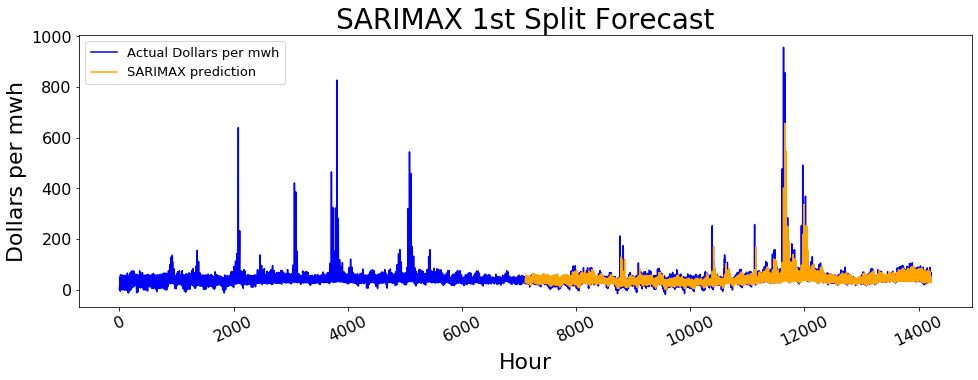

In [66]:
fig = plt.figure(figsize=(16,5))                               
plt.plot(ts[:14220], color='blue', label='Actual Dollars per mwh')
plt.plot(predictions[0], color='orange', label='SARIMAX prediction')

plt.legend(loc='best', fontsize=13)
plt.title('SARIMAX 1st Split Forecast', fontsize=28)
plt.xlabel('Hour', fontsize=22)
plt.ylabel('Dollars per mwh', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=25)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000.]),
 <a list of 7 Text xticklabel objects>)

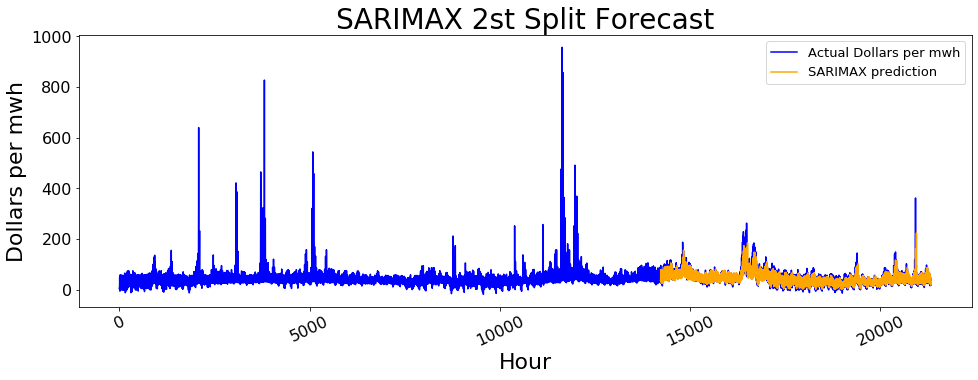

In [67]:
fig = plt.figure(figsize=(16,5))                               
plt.plot(ts[:21330], color='blue', label='Actual Dollars per mwh')
plt.plot(predictions[1], color='orange', label='SARIMAX prediction')

plt.legend(loc='best', fontsize=13)
plt.title('SARIMAX 2st Split Forecast', fontsize=28)
plt.xlabel('Hour', fontsize=22)
plt.ylabel('Dollars per mwh', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=25)

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 <a list of 8 Text xticklabel objects>)

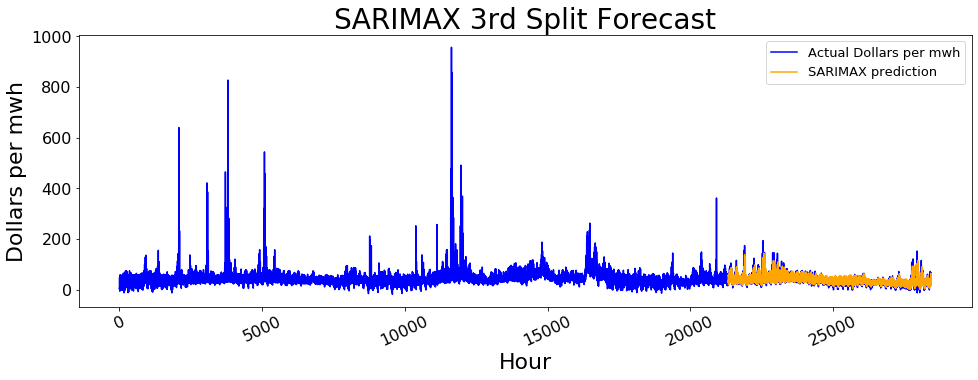

In [68]:
fig = plt.figure(figsize=(16,5))                               
plt.plot(ts[:28440], color='blue', label='Actual Dollars per mwh')
plt.plot(predictions[2], color='orange', label='SARIMAX prediction')

plt.legend(loc='best', fontsize=13)
plt.title('SARIMAX 3rd Split Forecast', fontsize=28)
plt.xlabel('Hour', fontsize=22)
plt.ylabel('Dollars per mwh', fontsize=22)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=25)

In [ ]:
from pmdarima import model_selection               #attempt at seperate CV and scoring, not successful
cv = model_selection.SlidingWindowForecastCV(window_size=6000, step=2000, h=1)

model2 = pm.ARIMA(order=(2, 0, 2),
                  seasonal_order=(2, 0, 2, 365),
                  suppress_warnings=False)
model2_cv_scores = model_selection.cross_val_score(
    model2, ts, exogenous=exogenous, scoring='mean_squared_error', cv=cv, verbose=2)

[CV] fold=0 ..........................................................


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



## FB Prophet

In [62]:
ts.head()

0    6.19784
1    2.89189
2    2.73622
3    2.88942
4    5.18543
Name: Dollars_per_mwh, dtype: float64

In [63]:
fb = ts.copy()
fb.head()

0    6.19784
1    2.89189
2    2.73622
3    2.88942
4    5.18543
Name: Dollars_per_mwh, dtype: float64

In [64]:
fb = pd.concat([df6['Date_time'], fb], axis=1)
fb.head()

,Date_time,Dollars_per_mwh
0,2017-03-27 00:00:00,6.19784
1,2017-03-27 01:00:00,2.89189
2,2017-03-27 02:00:00,2.73622
3,2017-03-27 03:00:00,2.88942
4,2017-03-27 04:00:00,5.18543


In [65]:
fb.columns = ['ds', 'y']
fb.head()

,ds,y
0,2017-03-27 00:00:00,6.19784
1,2017-03-27 01:00:00,2.89189
2,2017-03-27 02:00:00,2.73622
3,2017-03-27 03:00:00,2.88942
4,2017-03-27 04:00:00,5.18543
